# Data assimilation

In this task, we are exploring whether it has a gained value to assimilate the precipitation field computed by NWP and radar extrapolations by using Kalman Filter.

Methodologies pls refer to [A reduced space Kalman filter](https://journals.ametsoc.org/mwr/article/147/3/987/107474/A-Reduced-Space-Ensemble-Kalman-Filter-Approach)

In [1]:
import filterpy
import numpy
import matplotlib.pyplot as plt
from pysteps.utils import conversion, dimension, transformation
from osgeo import gdal
from numpy.random import randn
from filterpy.kalman import EnsembleKalmanFilter as EnKF
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import rasterio
import rasterio.mask
import rioxarray
import fiona
import multiprocessing
import os

Pysteps configuration file found at: /home/allen/Documents/Programs/miniconda3/envs/dl/lib/python3.7/site-packages/pysteps-1.3.1-py3.7-linux-x86_64.egg/pysteps/pystepsrc



In [2]:
shp_pth= '/home/allen/Documents/Projects/Harvey/excessive_rain/subbasins/08076700.shp'
with fiona.open(shp_pth, "r") as shapefile:
    geom_crs = shapefile.crs_wkt
    shapes = [feature["geometry"] for feature in shapefile]
QPE_dir='/home/allen/Documents/Projects/Ensemble_Nowcast/MRMS/20170826'
QPF_dir='/home/allen/Documents/Projects/Ensemble_Nowcast/extrapolation/20170826_adapt'

In [10]:
delta= pd.Timedelta('6M')
dr= pd.date_range('20170826120000', '20170826145400', freq='0.1H')

QPEs=[]
QPFs=[[]]
for hour in dr:
    print(hour)
    fname= hour.strftime('%Y%m%d%H%M%S.tif')
    QPE_pth= os.path.join(QPE_dir, fname)
    with rasterio.open(QPE_pth) as src:
        QPE, _ = rasterio.mask.mask(src, shapes, crop=True)
        QPE, _= transformation.dB_transform(QPE, threshold=.1, zerovalue=-15.0)
        QPE[np.isinf(QPE)]=-15.0
        QPEs.append(QPE)

    for mem in range(10):
        QPF_pth= os.path.join(QPF_dir, '2017082612', fname[:-4]+'_mem%02d.tif'%mem)
        with rasterio.open(QPF_pth) as src:
            _QPF=rasterio.mask.mask(src, shapes, crop=True)[0]
        _QPF,_= transformation.dB_transform(_QPF, threshold=.1, zerovalue=-15.0)
        _QPF[np.isinf(_QPF)]=-15.0
        QPFs[-1].append(_QPF)
    QPFs.append([])
del QPFs[-1]
QPFs= np.stack(QPFs).squeeze()[:,:,:,:-1]
QPEs= np.stack(QPEs).squeeze()

2017-08-26 12:00:00
2017-08-26 12:06:00
2017-08-26 12:12:00
2017-08-26 12:18:00
2017-08-26 12:24:00
2017-08-26 12:30:00
2017-08-26 12:36:00
2017-08-26 12:42:00
2017-08-26 12:48:00
2017-08-26 12:54:00
2017-08-26 13:00:00
2017-08-26 13:06:00
2017-08-26 13:12:00
2017-08-26 13:18:00
2017-08-26 13:24:00
2017-08-26 13:30:00
2017-08-26 13:36:00
2017-08-26 13:42:00
2017-08-26 13:48:00
2017-08-26 13:54:00
2017-08-26 14:00:00
2017-08-26 14:06:00
2017-08-26 14:12:00
2017-08-26 14:18:00
2017-08-26 14:24:00
2017-08-26 14:30:00
2017-08-26 14:36:00
2017-08-26 14:42:00
2017-08-26 14:48:00
2017-08-26 14:54:00


In [11]:
#read in HRRR
#hrrr.t12z.wrfsfcf00.grib2.rainrate_warp.tif
HRRRs= []
for i, hour in enumerate(pd.date_range('20170826120000', '20170826145400', freq='1H')):
    HRRR_fname= '/home/allen/Documents/Projects/Ensemble_Nowcast/HRRR/hrrr.t12z.wrfsfcf%02d.grib2.rainrate_warp.tif'%(i)

    with rasterio.open(HRRR_fname) as src:
        HRRR, _ = rasterio.mask.mask(src, shapes, crop=True,all_touched=True)
        HRRR*= 3600
        HRRR,_= transformation.dB_transform(HRRR, threshold=-1, zerovalue=-15.0)
        HRRR[np.isinf(HRRR)]=-15.0
        HRRRs.append(HRRR[:,:,:])
HRRRs=np.stack(HRRRs).squeeze()

# 1D Kalman filter

In [5]:
def hx(x):
    return np.array([x[0]])

def fx(x, dt):
    '''Update function, here we use extrapolated function'''
    return x[int(dt)+1]

# x = X[:,0,320,400]
# QPFs= np.nanmean(np.nanmean(QPFs,axis=3),axis=3).squeeze()

# enf.Q = Q_discrete_white_noise(2, 1., .001)

best_estimator= np.zeros((30,149,283)) * np.nan
upper_estimator= np.zeros((30,149,283)) * np.nan
lower_estimator= np.zeros((30,149,283)) * np.nan

time,mem,rows,cols= QPFs.shape
for row in range(rows):
    for col in range(cols):
        x= QPFs[0,:,row,col]
        P = np.eye(10) * 100.
        enf = EnKF(x=x, P=P, dim_z=1, dt=1., N=10, hx=hx, fx=fx)
        std_noise = 10.
        enf.R *= std_noise**2
        
        for t in range(time-1):
            if t%10==0:
                z= HRRRs[t//10,row, col]
            enf.predict()
            enf.update(np.asarray([z]))
            best_estimator[t+1,row,col]= enf.x[0]
            upper_estimator[t+1,row,col]= enf.x[0]+3*enf.P[0,0]**.5
            lower_estimator[t+1,row,col]= enf.x[0]-3*enf.P[0,0]**.5


In [6]:
def process(args):
    time,row,col= args
    x= QPFs[0,:,row,col]
    P = np.eye(10) * 100.
    enf = EnKF(x=x, P=P, dim_z=1, dt=1., N=10, hx=hx, fx=fx)
    std_noise = 2.
    enf.R *= std_noise**2
    median= np.zeros(time)* np.nan
    upper= np.zeros(time)* np.nan
    lower= np.zeros(time)* np.nan
    median[0]= np.nanmedian(x)
    upper[0]= np.nanquantile(x,0.75)
    lower[0]= np.nanquantile(x,0.25)
    for t in range(time-1):
        if t%10==0 and t!=0:
            z= HRRRs[t//10,row, col]
            enf.update(np.asarray([z]))
        enf.predict()
        median[t+1]= enf.x[0]
        upper[t+1]= enf.x[0]+3*enf.P[0,0]**.5
        lower[t+1]= enf.x[0]-3*enf.P[0,0]**.5
        
    return (row, col, median, upper, lower)

def parallel():
    
    time,mem,rows,cols=QPFs.shape
    X= QPFs.reshape(time,mem,-1)

    args= [(time, row, col) for row in range(rows) for col in range(cols)]
    best_estimator= np.zeros((time,rows,cols)) * np.nan
    upper_estimator= np.zeros((time,rows,cols)) * np.nan
    lower_estimator= np.zeros((time,rows,cols)) * np.nan
    with multiprocessing.Pool(4) as pool:
        results= pool.map(process, args)
        
    for (m,n,med,up,low) in results:
        best_estimator[:,m,n]=med
        upper_estimator[:,m,n]=up
        lower_estimator[:,m,n]=low
        
    return best_estimator, upper_estimator, lower_estimator

best_estimator, upper_estimator, lower_estimator= parallel()

In [7]:
best_estimator,_= transformation.dB_transform(best_estimator, threshold=-10.0,inverse=True)
upper_estimator,_= transformation.dB_transform(upper_estimator, threshold=-10.0,inverse=True)
lower_estimator,_= transformation.dB_transform(lower_estimator, threshold=-10.0,inverse=True)

In [12]:
QPFs,_= transformation.dB_transform(QPFs, threshold=-10.0,inverse=True)
HRRRs,_= transformation.dB_transform(HRRRs, threshold=-10.0,inverse=True)
QPEs,_= transformation.dB_transform(QPEs, threshold=-10.0,inverse=True)

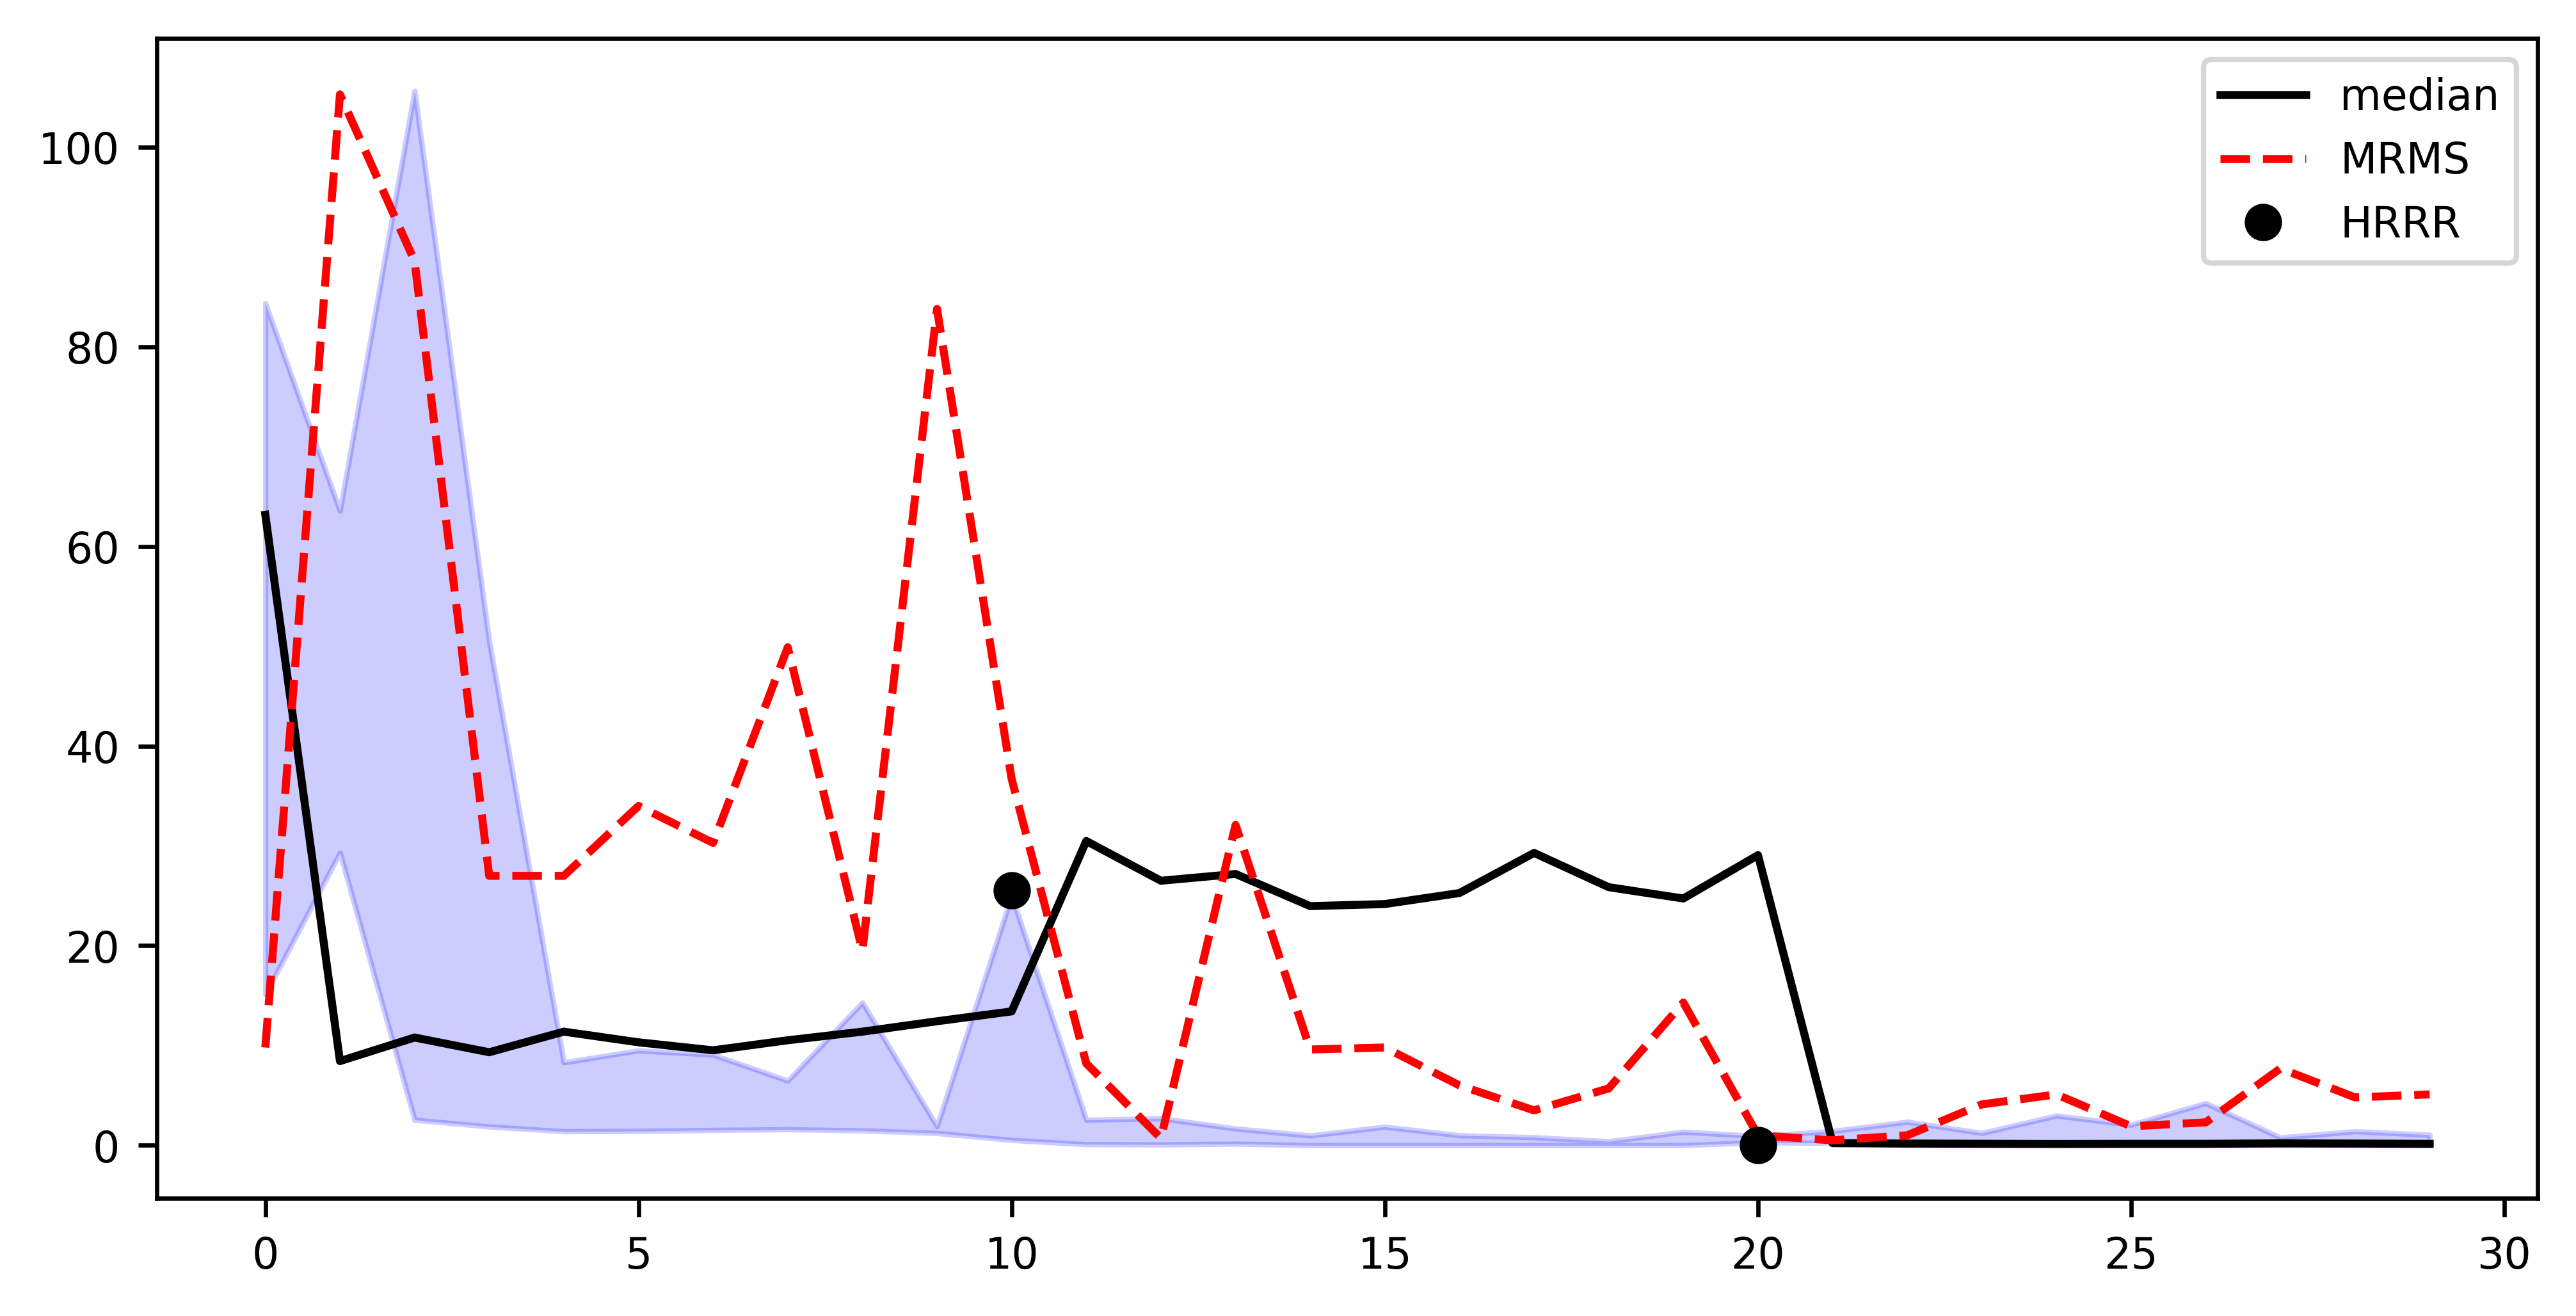

In [14]:
i=10;j=20
fig=plt.figure(figsize=(8,4))
plt.plot(best_estimator[:,i,j], label='median')
# plt.plot(upper_estimator[:,i,j], label='+1$\sigma$')
# plt.plot(lower_estimator[:,i,j], label='-1$\sigma$')
plt.fill_between(range(30),np.nanquantile(QPFs[:,:,i,j],0.25,axis=1),
                 np.nanquantile(QPFs[:,:,i,j],0.75,axis=1),alpha=0.2, color='b')
plt.plot(QPEs[:,i,j], label='MRMS')
plt.plot([10,20], HRRRs[1:,i,j],'ko', label='HRRR')
plt.legend()

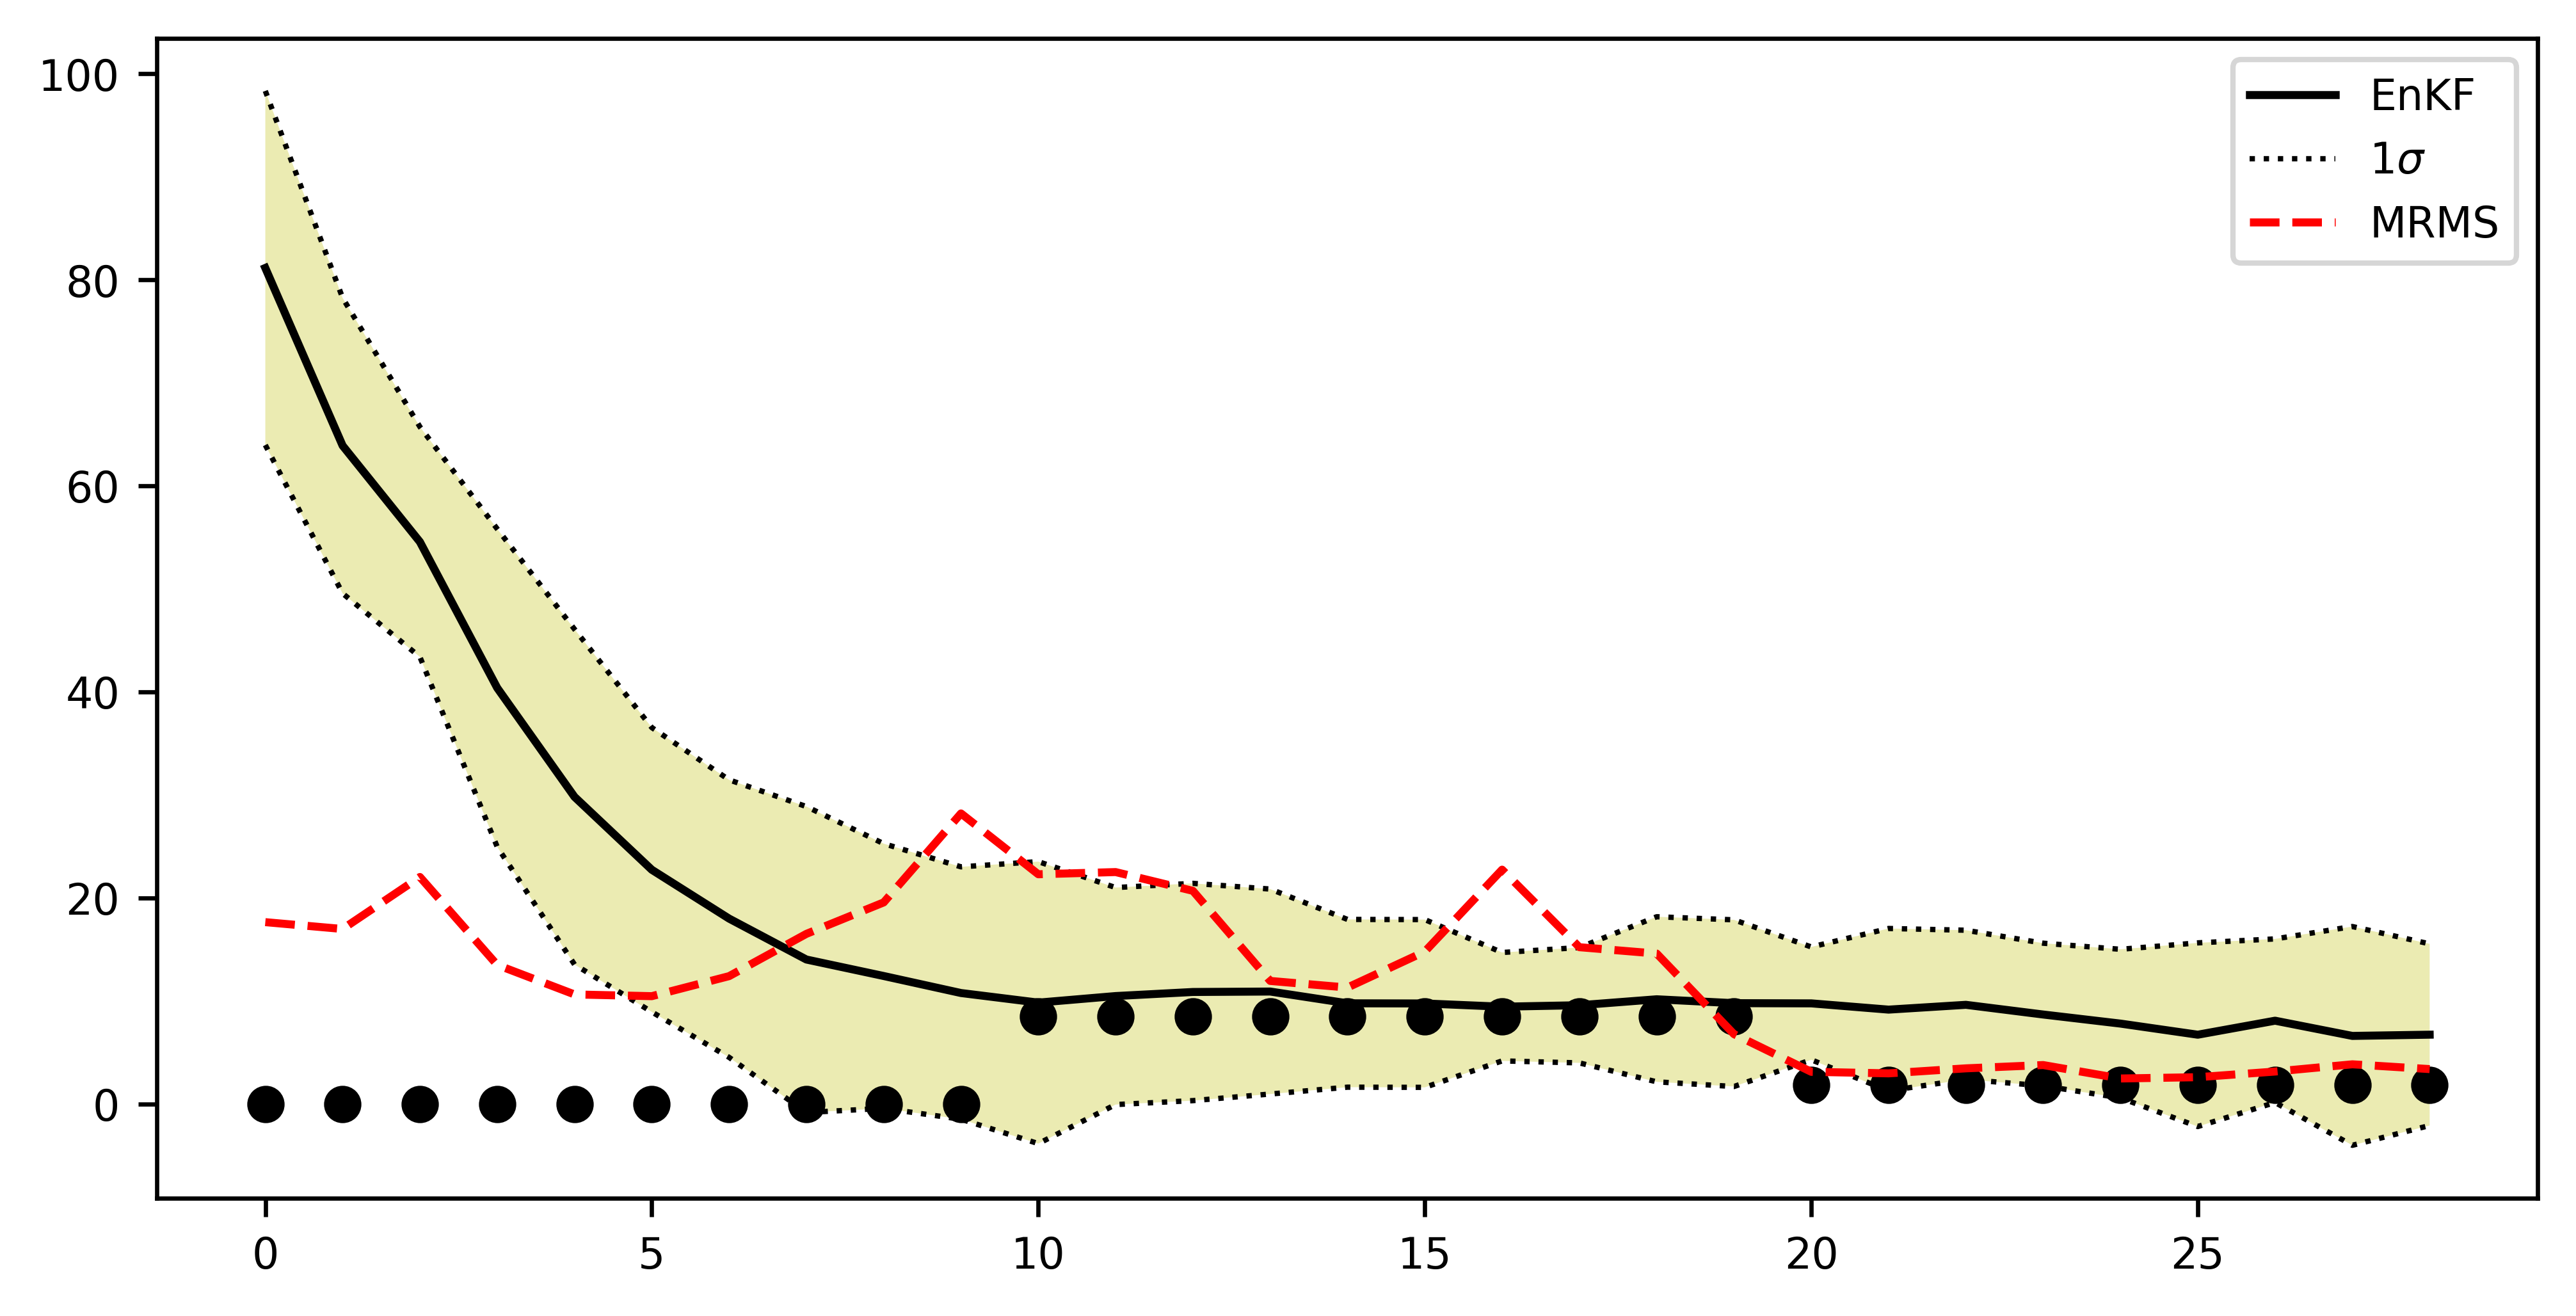

In [53]:
results = np.asarray(results)
ps = np.asarray(ps)
fig= plt.figure(figsize=(8,4))
plt.plot(results, label='EnKF')
plt.plot(measurements,'ko')
plt.plot (results - ps, c='k',linestyle=':', lw=1, label='1$\sigma$')
plt.plot(results + ps, c='k', linestyle=':', lw=1)
plt.fill_between(range(29), results - ps, results + ps, facecolor='y', alpha=.3)
plt.plot(range(29), true[1:], label='MRMS')
plt.plot()
plt.legend(loc='best');

# Space-reduced Kalman Filter

In [13]:
from sklearn import decomposition


In [14]:
def standardize(x):
    mean= np.nanmean(x,axis=0)
    std= x.std(axis=0)
    res= (x-mean)/std
    
    return res, mean, std

def inverse_standardize(x,mean,std):
    return x*std+mean



In [19]:
time,mem,rows,cols= QPFs.shape

In [20]:
X= QPFs[10,:,:,:].squeeze().reshape(10,-1)
Z= HRRRs[1,:,:].squeeze().reshape(1,-1)
Y= np.concatenate([X,Z], axis=0)
Y, mean, std= standardize(Y)
invalid_ind= np.where(np.isnan(Y[0]))[0]
valid_ind= np.where(~np.isnan(Y[0]))[0]

Y_clean= np.delete(Y, invalid_ind, axis=1)


In [21]:
pca= decomposition.PCA(n_components=10)

Y_d= pca.fit_transform(Y_clean)
U= pca.components_

In [22]:
x= Y_clean[:-1]
z= Y_clean[-1]

n,m=x.shape
x_d= x.dot(U.T).mean(axis=0)
P_d= (x.dot(U.T)-x_d.T).T.dot(x.dot(U.T)-x_d.T)
z_d= z.dot(U.T).mean(axis=0)

R_d= np.eye(10,10)
K_d= P_d.dot(np.linalg.inv(P_d+R_d))
x_next= (x.dot(U.T)+K_d.dot(z.dot(U.T)-x.dot(U.T))).dot(U)

In [23]:
x_next= inverse_standardize(x_next, mean[valid_ind], std[valid_ind])
x_next, _= transformation.dB_transform(x_next, threshold=-10.0,
                                              zerovalue=-15.0,inverse=True)

In [26]:
rain_en= np.zeros((10,rows*cols))* np.nan
rain_en[:,valid_ind]= x_next
rain_en= rain_en.reshape(10,rows,cols)

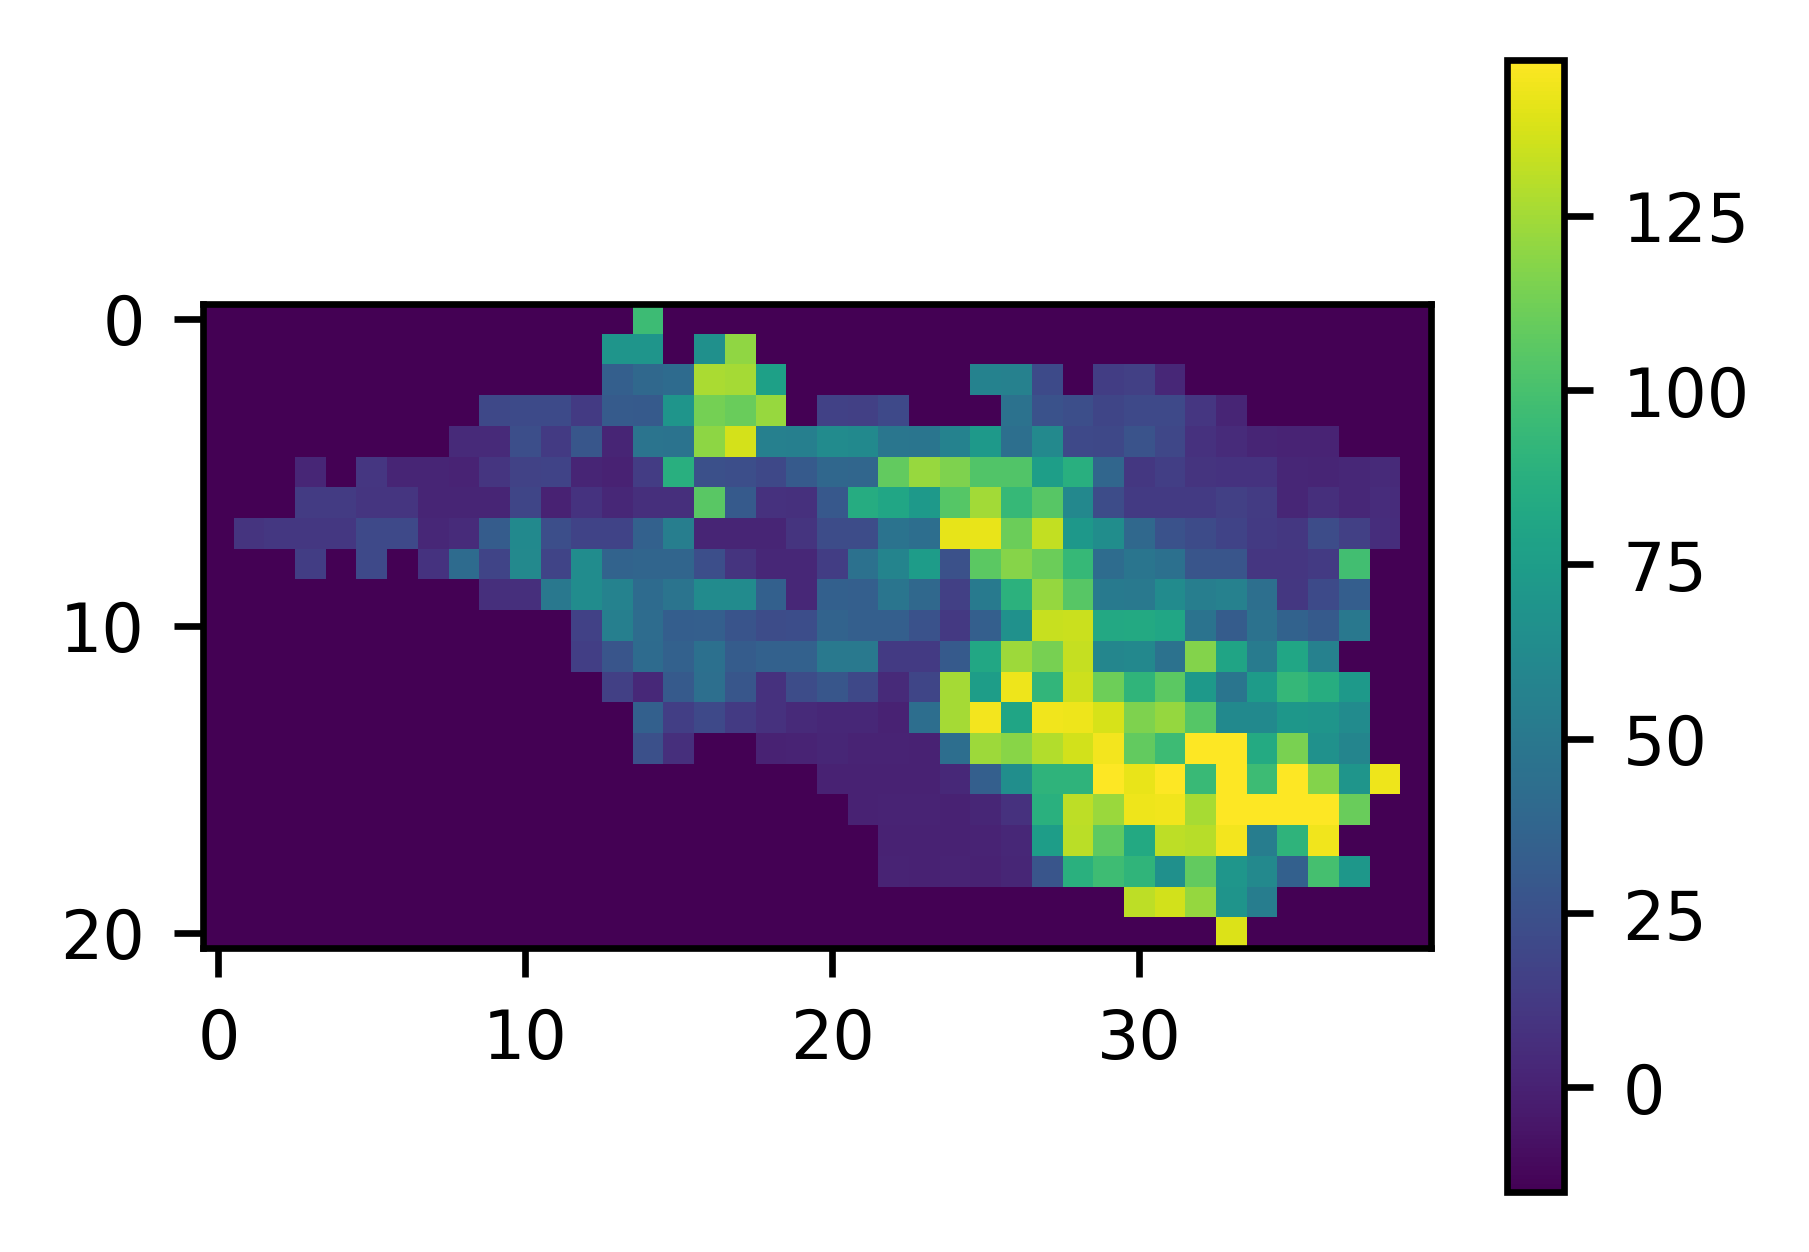

In [50]:
plt.imshow(QPEs[10])
plt.colorbar()

In [19]:
plt.imshow(np.nanmean(rain_en,axis=0))
plt.colorbar()

NameError: name 'rain_en' is not defined